# US Accidents (2016 - 2023)
A Countrywide Traffic Accident Dataset



In [29]:
# Step 0: Import Necessary Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [30]:
# Set display options for better viewing
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)

In [31]:
# Step 1: Load the Data
print("Step 1: Loading data...")
# Replace with your actual file path
df = pd.read_csv('US_Accidents_dataset.csv')
print(f"Original data shape: {df.shape}")


Step 1: Loading data...
Original data shape: (1999, 46)


In [32]:
# Step 2: Initial Inspection
print("\nStep 2: Initial inspection...")
print("First few rows:")
print(df.head())
print("\nDataset info:")
print(df.info())
print("\nMissing values per column:")
missing_summary = df.isnull().sum().sort_values(ascending=False)
missing_percentage = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
missing_df = pd.DataFrame({
    'Missing Values': missing_summary,
    'Percentage (%)': missing_percentage
})
print(missing_df[missing_df['Missing Values'] > 0])


Step 2: Initial inspection...
First few rows:
    ID   Source  Severity        Start_Time          End_Time  Start_Lat  Start_Lng  End_Lat  End_Lng  Distance(mi)                                        Description                     Street          City      County State     Zipcode Country    Timezone Airport_Code Weather_Timestamp  Temperature(F)  Wind_Chill(F)  Humidity(%)  Pressure(in)  Visibility(mi) Wind_Direction  Wind_Speed(mph)  Precipitation(in) Weather_Condition  Amenity   Bump  Crossing  Give_Way  Junction  No_Exit  Railway  Roundabout  Station   Stop  Traffic_Calming  Traffic_Signal  Turning_Loop Sunrise_Sunset Civil_Twilight Nautical_Twilight Astronomical_Twilight
0  A-1  Source2         3  08-02-2016 05:46  08-02-2016 11:00  39.865147 -84.058723      NaN      NaN          0.01  Right lane blocked due to accident on I-70 Eas...                     I-70 E        Dayton  Montgomery    OH       45424      US  US/Eastern         KFFO  08-02-2016 05:58            36.9        

In [33]:
# Step 3: Handle Missing Values Strategically
print("\nStep 3: Handling missing values...")

# Drop columns with too many missing values (adjust threshold as needed)
columns_to_drop = missing_df[missing_df['Percentage (%)'] > 70].index.tolist()
print(f"Dropping columns with >70% missing values: {columns_to_drop}")
df_clean = df.drop(columns=columns_to_drop)

# Create missingness indicators for important columns before imputation
weather_columns = ['Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
                  'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)']

for col in weather_columns:
    if col in df_clean.columns:
        df_clean[f'{col}_missing'] = df_clean[col].isnull().astype(int)

# Separate numerical and categorical columns
numerical_cols = df_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_cols = df_clean.select_dtypes(include=['object', 'bool']).columns.tolist()

# Remove target variable if present (for prediction tasks)
if 'Severity' in numerical_cols:
    numerical_cols.remove('Severity')
if 'Severity' in categorical_cols:
    categorical_cols.remove('Severity')

print(f"Numerical columns: {numerical_cols}")
print(f"Categorical columns: {categorical_cols}")


Step 3: Handling missing values...
Dropping columns with >70% missing values: ['End_Lng', 'End_Lat', 'Precipitation(in)', 'Wind_Chill(F)']
Numerical columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Temperature(F)_missing', 'Humidity(%)_missing', 'Pressure(in)_missing', 'Visibility(mi)_missing', 'Wind_Speed(mph)_missing']
Categorical columns: ['ID', 'Source', 'Start_Time', 'End_Time', 'Description', 'Street', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight']



Step 4: Handling outliers...
  - Distance(mi): 17 outliers found (lower: -0.01, upper: 0.03)
  - Pressure(in): 172 outliers found (lower: 29.64, upper: 30.28)
  - Visibility(mi): 362 outliers found (lower: 7.50, upper: 11.50)
  - Wind_Speed(mph): 46 outliers found (lower: -3.20, upper: 20.80)

Outlier handling summary:
  - Distance(mi): 17 outliers capped
  - Pressure(in): 172 outliers capped
  - Visibility(mi): 362 outliers capped
  - Wind_Speed(mph): 46 outliers capped
  Total outliers capped: 597


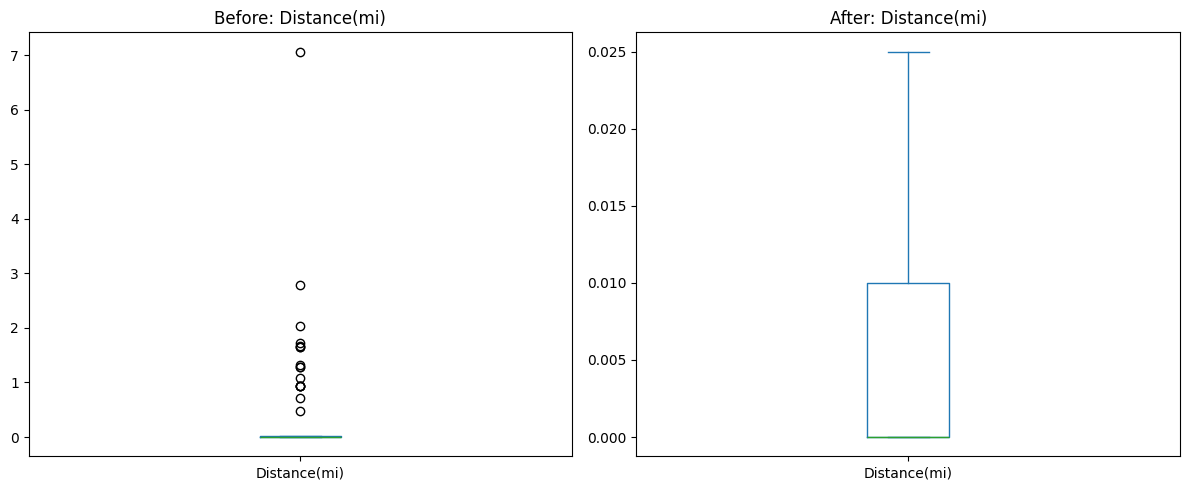

In [34]:
# Step 4: Handle Outliers
print("\nStep 4: Handling outliers...")

def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1  # Fixed the variable name (was '10R' which is invalid)
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Identify outliers before capping
    outliers_mask = (df[column] < lower_bound) | (df[column] > upper_bound)
    num_outliers = outliers_mask.sum()

    if num_outliers > 0:
        print(f"  - {column}: {num_outliers} outliers found (lower: {lower_bound:.2f}, upper: {upper_bound:.2f})")

    # Cap outliers instead of removing them
    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])

    return df, num_outliers

# Apply to numerical columns (be careful with this - know your data first!)
total_outliers = 0
outlier_report = {}

for col in numerical_cols:
    if df_clean[col].nunique() > 10:  # Only for continuous variables
        df_clean, num_outliers = handle_outliers(df_clean, col)
        outlier_report[col] = num_outliers
        total_outliers += num_outliers

# Print a summary report
print(f"\nOutlier handling summary:")
if total_outliers == 0:
    print("  No outliers found in continuous numerical columns.")
else:
    for col, count in outlier_report.items():
        if count > 0:
            print(f"  - {col}: {count} outliers capped")
    print(f"  Total outliers capped: {total_outliers}")

# Optional: Show boxplot before and after for a specific column
if total_outliers > 0:
    # Pick a column that had outliers to visualize
    example_col = next((col for col, count in outlier_report.items() if count > 0), None)

    if example_col:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

        # Before handling
        df[example_col].plot(kind='box', ax=ax1)
        ax1.set_title(f'Before: {example_col}')

        # After handling
        df_clean[example_col].plot(kind='box', ax=ax2)
        ax2.set_title(f'After: {example_col}')

        plt.tight_layout()
        plt.savefig('outlier_handling_comparison.png')
        plt.show()

In [35]:
# Step 5: Feature Engineering
print("\nStep 5: Feature engineering...")

# 5.1: Handle DateTime Conversion Safely
if 'Start_Time' in df_clean.columns:
    print("  Converting 'Start_Time' to datetime...")

    # Save the original column to compare for errors
    original_length = len(df_clean)

    # Convert to datetime, forcing errors to become 'NaT' (Not a Time)
    df_clean['Start_Time'] = pd.to_datetime(df_clean['Start_Time'], errors='coerce')

    # Check for parsing failures
    nat_count = df_clean['Start_Time'].isna().sum()
    if nat_count > 0:
        print(f"  Warning: Failed to parse {nat_count} datetime entries. They have been set to NaN.")
        # Show examples of problematic data
        problematic_rows = df_clean[df_clean['Start_Time'].isna()]
        print(f"  Example of a problematic row index: {problematic_rows.index[0] if len(problematic_rows) > 0 else 'N/A'}")
        # Option: Drop rows where datetime parsing failed if they are a small minority
        if nat_count / original_length < 0.05: # If less than 5% are problematic
            df_clean = df_clean.dropna(subset=['Start_Time'])
            print(f"  Dropped {nat_count} rows with invalid datetime.")
        else:
            print("  Keeping rows with NaN datetime for manual inspection.")

    # 5.2: Extract Time-Based Features (Only from valid dates)
    print("  Extracting time-based features...")
    valid_time_mask = df_clean['Start_Time'].notna()

    df_clean.loc[valid_time_mask, 'hour'] = df_clean.loc[valid_time_mask, 'Start_Time'].dt.hour
    df_clean.loc[valid_time_mask, 'day_of_week'] = df_clean.loc[valid_time_mask, 'Start_Time'].dt.dayofweek # Monday=0, Sunday=6
    df_clean.loc[valid_time_mask, 'month'] = df_clean.loc[valid_time_mask, 'Start_Time'].dt.month
    df_clean.loc[valid_time_mask, 'year'] = df_clean.loc[valid_time_mask, 'Start_Time'].dt.year

    # Create time-based features
    df_clean['is_rush_hour'] = ((df_clean['hour'] >= 7) & (df_clean['hour'] <= 9)) | \
                              ((df_clean['hour'] >= 16) & (df_clean['hour'] <= 18))
    df_clean['is_weekend'] = df_clean['day_of_week'] >= 5 # 5 and 6 correspond to Saturday and Sunday

    # Fill NaN in new columns created from datetime (for rows where parsing failed) with a default value (e.g., -1) or median/mode
    # Alternatively, you can drop these rows if you dropped the NaT above.
    time_derived_cols = ['hour', 'day_of_week', 'month', 'year', 'is_rush_hour', 'is_weekend']
    for col in time_derived_cols:
        if col in df_clean.columns:
            # Check if the column has NaNs (from failed datetime parsing)
            if df_clean[col].isna().any():
                # For categorical/time features, using the mode (most common value) is often sensible
                fill_val = df_clean[col].mode()[0] if not df_clean[col].mode().empty else -1
                df_clean[col].fillna(fill_val, inplace=True)
                print(f"    Filled NaNs in '{col}' with value: {fill_val}")

else:
    print("  Column 'Start_Time' not found. Skipping datetime feature engineering.")

# 5.3: (Optional) Create a 'season' feature from the month
if 'month' in df_clean.columns:
    print("  Creating 'season' feature...")
    # Define a function to map month to season
    def get_season(month):
        if month in [12, 1, 2]:
            return 'Winter'
        elif month in [3, 4, 5]:
            return 'Spring'
        elif month in [6, 7, 8]:
            return 'Summer'
        elif month in [9, 10, 11]:
            return 'Fall'
        else:
            return 'Unknown'

    df_clean['season'] = df_clean['month'].apply(get_season)

print("  Feature engineering step completed.")


Step 5: Feature engineering...
  Converting 'Start_Time' to datetime...
  Example of a problematic row index: 129
  Keeping rows with NaN datetime for manual inspection.
  Extracting time-based features...
    Filled NaNs in 'hour' with value: 7.0
    Filled NaNs in 'day_of_week' with value: 6.0
    Filled NaNs in 'month' with value: 3.0
    Filled NaNs in 'year' with value: 2016.0
  Creating 'season' feature...
  Feature engineering step completed.


/tmp/ipython-input-2704471169.py:51: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean[col].fillna(fill_val, inplace=True)


In [36]:
# Step 6: Encode Categorical Variables
print("\nStep 6: Encoding categorical variables...")

# 6.1: Handle High-Cardinality Columns by Grouping Rare Categories
def reduce_cardinality(series, threshold=0.01):
    counts = series.value_counts(normalize=True)
    mask = series.isin(counts[counts < threshold].index)
    series = series.where(~mask, 'Other')
    return series

print("  Reducing cardinality for high-cardinality features...")
high_cardinality_cols = ['City', 'County', 'Zipcode', 'Weather_Condition']
for col in high_cardinality_cols:
    if col in df_clean.columns:
        unique_before = df_clean[col].nunique()
        df_clean[col] = reduce_cardinality(df_clean[col])
        unique_after = df_clean[col].nunique()
        print(f"    {col}: Reduced from {unique_before} to {unique_after} categories.")

# 6.2: Convert Boolean Columns to 0/1
print("  Converting boolean columns to integers...")
bool_cols = df_clean.select_dtypes(include=['bool']).columns
for col in bool_cols:
    df_clean[col] = df_clean[col].astype(int)
    print(f"    Converted {col} to int.")

# 6.3: Identify Categorical Columns for Encoding
# Get all object (string) columns that are not high-cardinality or are already reduced
categorical_cols_for_encoding = df_clean.select_dtypes(include=['object']).columns.tolist()

# Define columns that should NOT be one-hot encoded (IDs, free text, etc.)
# Add any other non-feature columns you plan to drop later
cols_to_exclude = ['ID', 'Description', 'Street', 'Number', 'Address']
categorical_cols_for_encoding = [col for col in categorical_cols_for_encoding if col not in cols_to_exclude]

print(f"  Categorical columns to be encoded: {categorical_cols_for_encoding}")

# 6.4: Choose an Encoding Strategy
# Strategy 1: Label Encoding for Ordinal Data (if any natural order exists)
# Example: If you had a "Size" column with values ['Small', 'Medium', 'Large']
# from sklearn.preprocessing import LabelEncoder
# le = LabelEncoder()
# df_clean['Size_encoded'] = le.fit_transform(df_clean['Size'])

# Strategy 2: One-Hot Encoding for Nominal Data (No natural order)
print("  Performing one-hot encoding...")
# Use pd.get_dummies for simplicity. Alternatively, use sklearn's OneHotEncoder in the pipeline later.
df_clean = pd.get_dummies(df_clean,
                          columns=categorical_cols_for_encoding,
                          prefix=categorical_cols_for_encoding,
                          drop_first=False, # Set to True to avoid multicollinearity (Dummy Variable Trap)
                          dummy_na=False) # We've already handled missing values

print(f"  New data shape after one-hot encoding: {df_clean.shape}")

# 6.5: (Optional) Alternative for VERY High Cardinality: Target Encoding
# If a column still has too many categories even after grouping (e.g., 50+),
# one-hot encoding might create too many features. Use target encoding instead.
# from category_encoders import TargetEncoder
# te = TargetEncoder()
# df_clean['High_Card_Col_encoded'] = te.fit_transform(df_clean['High_Card_Col'], df_clean['Target'])

print("Step 6: Encoding completed.")


Step 6: Encoding categorical variables...
  Reducing cardinality for high-cardinality features...
    City: Reduced from 271 to 14 categories.
    County: Reduced from 58 to 18 categories.
    Zipcode: Reduced from 883 to 3 categories.
    Weather_Condition: Reduced from 20 to 10 categories.
  Converting boolean columns to integers...
    Converted Amenity to int.
    Converted Bump to int.
    Converted Crossing to int.
    Converted Give_Way to int.
    Converted Junction to int.
    Converted No_Exit to int.
    Converted Railway to int.
    Converted Roundabout to int.
    Converted Station to int.
    Converted Stop to int.
    Converted Traffic_Calming to int.
    Converted Traffic_Signal to int.
    Converted Turning_Loop to int.
    Converted is_rush_hour to int.
    Converted is_weekend to int.
  Categorical columns to be encoded: ['Source', 'End_Time', 'City', 'County', 'State', 'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp', 'Wind_Direction', 'Weather

In [37]:
# Step 7: Final Preparation for Machine Learning
print("\nStep 7: Final preparation for machine learning...")

# 7.1: Define the lists of columns we might want to remove
# This is a comprehensive list. The code will only try to remove those that actually exist.
non_feature_cols = ['ID', 'Start_Time', 'End_Time', 'Description', 'Street', 'Country', 'Timestamp']
# Create a list of columns that are actually PRESENT in the current DataFrame
cols_to_drop = [col for col in non_feature_cols if col in df_clean.columns]
print(f"  Non-feature columns to be removed: {cols_to_drop}")

# 7.2: Ensure all data is numeric (a final check)
print("  Ensuring all data is numeric...")
non_numeric_cols = df_clean.select_dtypes(include=['object', 'bool']).columns.tolist()
if non_numeric_cols:
    print(f"  Warning: Non-numeric columns found: {non_numeric_cols}")
    print("  Attempting to convert them...")
    for col in non_numeric_cols:
        if df_clean[col].dtype == 'bool':
            df_clean[col] = df_clean[col].astype(int)
            print(f"    Converted {col} from bool to int.")
        else:
            # Use factorize for object columns: assigns a number to each unique category
            df_clean[col], _ = pd.factorize(df_clean[col])
            print(f"    Factorized {col} from object to int.")
else:
    print("  All columns are numeric. Good to go.")

# 7.3: Define Target Variable and Features
print("  Separating target variable from features...")
target_column = 'Severity'  # Change this to your actual target column name

if target_column not in df_clean.columns:
    print(f"  Warning: Target column '{target_column}' not found.")
    print("  Proceeding without a target for unsupervised learning.")
    y = None
    X = df_clean.drop(columns=cols_to_drop) # Only drop non-feature columns
else:
    y = df_clean[target_column]  # Target variable
    # Create feature matrix by dropping target AND non-feature columns
    # Only try to drop columns that actually exist in the DataFrame
    all_cols_to_drop = [target_column] + cols_to_drop
    # Final safety check: ensure each column to drop exists
    existing_cols_to_drop = [col for col in all_cols_to_drop if col in df_clean.columns]
    X = df_clean.drop(columns=existing_cols_to_drop)
    print(f"  Target variable '{target_column}' separated. Shape of y: {y.shape}")

print(f"  Final feature matrix (X) shape: {X.shape}")
if y is not None:
    print(f"  Final target vector (y) shape: {y.shape}")

# 7.4: Create a Final Scaler
print("  Creating final scaling pipeline...")
# Identify final numerical columns (everything in X should be numeric now)
numerical_cols_final = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
print(f"  Columns to be scaled: {numerical_cols_final}")

if numerical_cols_final: # Only create a scaler if there are numerical columns
    final_scaler = StandardScaler()
    # Fit and transform the numerical columns
    X_scaled = final_scaler.fit_transform(X[numerical_cols_final])
    # Create a DataFrame for the scaled numerical features
    X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols_final)
    # Combine scaled numerical features with non-numerical features (if any)
    non_numerical_cols = X.select_dtypes(exclude=['int64', 'float64']).columns
    if not non_numerical_cols.empty:
        X_final = pd.concat([X_scaled_df, X[non_numerical_cols]], axis=1)
    else:
        X_final = X_scaled_df
else:
    print("  No numerical columns to scale.")
    X_final = X

# 7.5: Create the final processed DataFrame
df_processed = X_final.copy()
print("Step 7: Final preparation completed.")
print(f"  Absolutely final dataset shape: {df_processed.shape}")
print("\nFirst 3 rows of the final processed dataset:")
print(df_processed.head(3))


Step 7: Final preparation for machine learning...
  Non-feature columns to be removed: ['ID', 'Start_Time', 'Description', 'Street']
  Ensuring all data is numeric...
  Attempting to convert them...
    Factorized ID from object to int.
    Factorized Description from object to int.
    Factorized Street from object to int.
    Converted Source_Source2 from bool to int.
    Converted Source_Source3 from bool to int.
    Converted End_Time_01-03-2016 05:35 from bool to int.
    Converted End_Time_01-03-2016 06:44 from bool to int.
    Converted End_Time_01-03-2016 08:00 from bool to int.
    Converted End_Time_01-03-2016 08:01 from bool to int.
    Converted End_Time_01-03-2016 08:16 from bool to int.
    Converted End_Time_01-03-2016 08:46 from bool to int.
    Converted End_Time_01-03-2016 10:36 from bool to int.
    Converted End_Time_01-03-2016 10:49 from bool to int.
    Converted End_Time_01-03-2016 11:11 from bool to int.
    Converted End_Time_01-03-2016 11:42 from bool to int.

In [38]:
# Step 8: Final Data Preparation, Summary, and Train-Test Split
print("\nStep 8: Final data preparation and train-test split...")

# 8.1: The features (X_final) and target (y) are already prepared from Step 7.
X = df_processed  # Our fully processed feature matrix from Step 7
# y is already defined in Step 7

# 8.2: FINAL SUMMARY
print("\n  --- Final Clean Dataset Summary ---")
print(f"  Final Dataset Shape: {X.shape}")
print("\n  First 3 rows of processed data:")
print(X.head(3))
print(f"\n  Total missing values in final dataset: {X.isnull().sum().sum()}")
# Check data types as a final sanity check
print(f"\n  Final data types:\n{X.dtypes.value_counts()}")
print("  ------------------------------------")

# 8.3: Perform Train-Test Split (CRUCIAL STEP)
if y is not None:
    from sklearn.model_selection import train_test_split
    print("  Performing train-test split...")
    # Split the data into training and testing sets (e.g., 80% train, 20% test)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    print(f"  Training set shape: X_train {X_train.shape}, y_train {y_train.shape}")
    print(f"  Testing set shape:  X_test {X_test.shape}, y_test {y_test.shape}")
else:
    print("  No target variable found. Skipping train-test split.")
    X_train, X_test, y_train, y_test = X, None, None, None

# 8.4: Save the Processed Datasets
print("  Saving processed datasets...")
X.to_csv('processed_features.csv', index=False)
if y is not None:
    y.to_csv('processed_target.csv', index=False)
    X_train.to_csv('X_train.csv', index=False)
    X_test.to_csv('X_test.csv', index=False)
    y_train.to_csv('y_train.csv', index=False)
    y_test.to_csv('y_test.csv', index=False)
    print("  All datasets saved for modeling.")
else:
    print("  Only feature matrix saved.")

print("Step 8: Final preparation, summary, and splitting completed.")


Step 8: Final data preparation and train-test split...

  --- Final Clean Dataset Summary ---
  Final Dataset Shape: (1999, 3359)

  First 3 rows of processed data:
   Start_Lat  Start_Lng  Distance(mi)  Temperature(F)  Humidity(%)  Pressure(in)  Visibility(mi)  Wind_Speed(mph)   Amenity  Bump  Crossing  Give_Way  Junction   No_Exit   Railway  Roundabout  Station    Stop  Traffic_Calming  Traffic_Signal  Turning_Loop  Temperature(F)_missing  Humidity(%)_missing  Pressure(in)_missing  Visibility(mi)_missing  Wind_Speed(mph)_missing      hour  day_of_week     month  year  is_rush_hour  is_weekend  Source_Source2  Source_Source3  End_Time_01-03-2016 05:35  End_Time_01-03-2016 06:44  End_Time_01-03-2016 08:00  End_Time_01-03-2016 08:01  End_Time_01-03-2016 08:16  End_Time_01-03-2016 08:46  End_Time_01-03-2016 10:36  End_Time_01-03-2016 10:49  End_Time_01-03-2016 11:11  End_Time_01-03-2016 11:42  End_Time_01-03-2016 12:26  End_Time_01-03-2016 13:20  End_Time_01-03-2016 13:51  End_Time_01-0


Step 9: Creating visualization of the cleaning process...
  Visualization saved as 'data_cleaning_comparison.png'


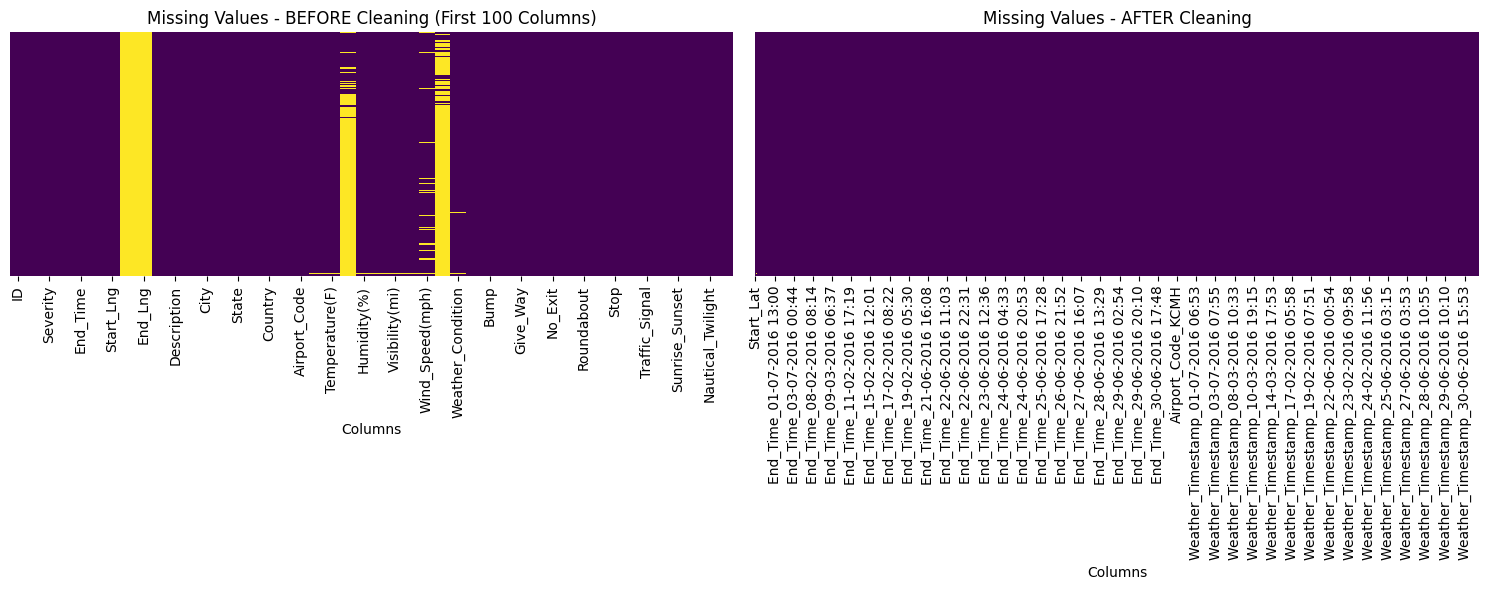

In [39]:
# Step 9: Visualization of Data Cleaning Process
print("\nStep 9: Creating visualization of the cleaning process...")

plt.figure(figsize=(15, 6))

# Subplot 1: Missing Data in the RAW Dataset (df)
plt.subplot(1, 2, 1)
# We only plot the first 100 columns for clarity, as the full dataset might be too wide
sns.heatmap(df.iloc[:, :100].isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values - BEFORE Cleaning (First 100 Columns)')
plt.xlabel('Columns')

# Subplot 2: Missing Data in the CLEANED Dataset (df_processed)
plt.subplot(1, 2, 2)
# Our cleaned dataframe should have no missing values, so this heatmap should be all yellow.
sns.heatmap(df_processed.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Values - AFTER Cleaning')
plt.xlabel('Columns')

plt.tight_layout()
plt.savefig('data_cleaning_comparison.png', dpi=100, bbox_inches='tight')
print("  Visualization saved as 'data_cleaning_comparison.png'")
plt.show()

In [40]:
# Final congratulatory message
print("\n" + "="*50)
print("PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!")
print("="*50)
print(f"The final cleaned dataset has shape: {df_processed.shape}")
print(f"Total missing values removed: {df.isnull().sum().sum() - df_processed.isnull().sum().sum()}")
print("Your data is now ready for machine learning!")


PREPROCESSING PIPELINE COMPLETED SUCCESSFULLY!
The final cleaned dataset has shape: (1999, 3359)
Total missing values removed: 7369
Your data is now ready for machine learning!
